<a href="https://colab.research.google.com/github/avocoder123/JobVerifier.ai/blob/main/job_verifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

1. Data Preprocessing
1.1 Handle Missing Data
* Fill missing values in text fields with an empty string ("").
* Fill missing values in categorical/numerical features with mode/median.
1.2 Feature Engineering
BERT Text Processing
* Concatenate key text fields for BERT input:python
* Tokenize and Encode using a pretrained BERT model (bert-base-uncased or similar).
* Convert text into dense embeddings using BERT's [CLS] token representation.
Structured Feature Processing
* Encode categorical variables (One-Hot or Label Encoding).
* Normalize numerical features (e.g., salary_range, text length stats).
1.3 Train-Test Split
* Split dataset (80%-20%) for training and testing.
* Ensure stratified splitting to maintain class balance.

2. Model Training
2.1 Train MLPClassifier on BERT Embeddings
* Input: BERT embeddings from [CLS] token.
* Hidden layers: Tune architecture ((100,50), ReLU, Dropout).
* Output: Probability of a job being fraudulent or real.
2.2 Train XGBoost on Structured Features
* Input: Encoded categorical/numerical fields.
* Optimize hyperparameters (n_estimators, max_depth, learning_rate).
* Output: Probability of fraud detection.

3. Model Combination (Ensemble)
* Take MLPClassifier and XGBoost output probabilities.
* Train a meta-classifier (e.g., Logistic Regression, another MLP, or a weighted average) on these outputs to make the final prediction.

4. Model Evaluation
* Compare individual model performance vs. the ensemble model.
* Use metrics:
    * Accuracy, Precision, Recall, F1-score
    * Confusion Matrix (False Positives/Negatives)
    * ROC-AUC Curve
* If needed, adjust the weighting of MLP vs. XGBoost in the meta-classifier.

5. Hyperparameter Tuning
* Use GridSearchCV or RandomizedSearchCV to optimize:
    * MLP layer sizes, activation functions, dropout rate.
    * XGBoost tree depth, learning rate, n_estimators.

6. Deployment (Optional)
* Save trained models (joblib or pickle).
* Deploy via an API (Flask or FastAPI) for real-time job classification.

---



Job Verifier

In [2]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 102.9 MB/s eta 0:00:00


In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
import kagglehub
import pandas as pd
import torch_xla.core.xla_model as xm  # TPU Support
import category_encoders as ce

# Download latest version
path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
jobs = pd.read_csv(path + "/fake_job_postings.csv")

# drop rows with missing values in the 'fraudulent' column
# This column is the target variable for our analysis
jobs = jobs.dropna(subset=['fraudulent'])

# replace missing values with empty strings
jobs = jobs.fillna("")

#TODO fill null categorical columns with zeros
jobs.head()

/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


100%|██████████| 16.1M/16.1M [00:00<00:00, 215MB/s]

Extracting files...


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
print(jobs.shape)
jobs.info()
# get the count of fraudulent and non-fraudulent job postings


(17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17880 non-null  object
 3   department           17880 non-null  object
 4   salary_range         17880 non-null  object
 5   company_profile      17880 non-null  object
 6   description          17880 non-null  object
 7   requirements         17880 non-null  object
 8   benefits             17880 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      17880 non-null  object
 13  required_experience  17880 non-null  object
 14  required_education   17880 non-null  object
 15  industry             17880 non-null  obje

In [5]:
jobs.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


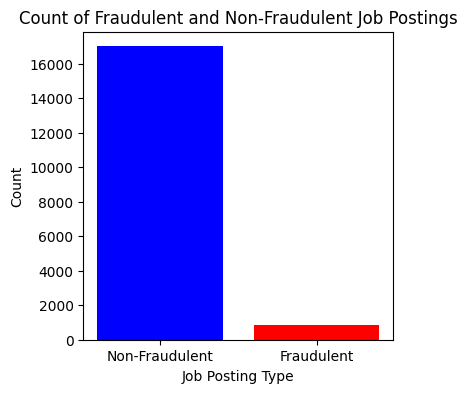

In [ ]:
fraudulent_counts = jobs['fraudulent'].value_counts()
non_fraudulent_count = fraudulent_counts[0]
fraudulent_count = fraudulent_counts[1]

# graph the count of fraudulent and non-fraudulent job postings
plt.figure(figsize=(4, 4))

plt.title('Count of Fraudulent and Non-Fraudulent Job Postings')

plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])

plt.ylabel('Count')
plt.xlabel('Job Posting Type')

plt.bar([0, 1], [non_fraudulent_count, fraudulent_count], color=['blue', 'red'])
plt.show()

# Feature Processing | BERT Embeddings

In [6]:
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# set the random seed for reproducibility
random.seed(42)

# load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# combine releavant text columns into a single column
texts = jobs['combined_text'] = jobs[['title', 'company_profile', 'description', 'requirements', 'benefits']].fillna("").agg(' '.join, axis=1)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
# batch encode the texts to reduce memory load

import gc
gc.collect()
torch.cuda.empty_cache()

batch_size = 256
embeddings = []

#tried batching but memory load was too high
# switched to TPU to handle computational lode after encountering memory issues
model = model.to(xm.xla_device())

with torch.no_grad():
  for i in range(0, len(texts), batch_size):
      batch_texts = texts[i:i+batch_size]

      encoding = tokenizer.batch_encode_plus(
          batch_texts,
          truncation=True,
          padding=True,
          return_tensors='pt',
          add_special_tokens=True
      )
      input_ids = encoding['input_ids'].to(xm.xla_device())
      attention_mask = encoding['attention_mask'].to(xm.xla_device())

      # Generate embeddings using BERT model
      outputs = model(input_ids, attention_mask=attention_mask)
      # get the embeddings from the last hidden state
      batch_embeddings = outputs.pooler_output.cpu().cpu()

      embeddings.append(batch_embeddings)

      # clear memory cache
      del input_ids, attention_mask, outputs
      gc.collect()
      torch.cuda.empty_cache()

# concatenate the embeddings from all batches
embeddings = torch.cat(embeddings, dim=0)


In [8]:
print(embeddings.shape)

torch.Size([17880, 768])


# Encoding Categorical Features

In [9]:

import category_encoders as ce
from sklearn.preprocessing import StandardScaler

# Identify categorical features
categorical = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

#Target encoding on categorical features
target_encode = ce.TargetEncoder(cols=categorical)
jobs_encoded = target_encode.fit_transform(jobs[categorical], jobs['fraudulent'])

#Normalise the encoded values
scaler = StandardScaler()
jobs_encoded_scaled = scaler.fit_transform(jobs_encoded)

# MERGE BERT EMBEDDINGS WITH CATEGORICAL FEATURES

In [12]:
tensor_jobs_encoded = torch.tensor(jobs_encoded_scaled, dtype=torch.float32)
print(tensor_jobs_encoded.shape)

print(f"Original Data Rows: {len(jobs)}")
print(f"BERT Embeddings Shape: {embeddings.shape}")  # Should be (N, D)
print(f"Encoded Categorical Shape: {tensor_jobs_encoded.shape}")  # Should be (N, D')

torch.Size([17880, 5])
Original Data Rows: 17880
BERT Embeddings Shape: torch.Size([17880, 768])
Encoded Categorical Shape: torch.Size([17880, 5])


In [13]:
merged_embeddings = torch.cat((embeddings, tensor_jobs_encoded), dim=1)
print(merged_embeddings.shape)

torch.Size([17880, 773])


# SPLIT DATASET

In [14]:
from sklearn.model_selection import train_test_split
#split dataset

X_train, X_test, y_train, y_test = train_test_split(merged_embeddings, jobs['fraudulent'], test_size=0.2, random_state=42)


## Split Dataset



In [15]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}


Handling Imbalanced Dataset (SMOTE)

In [18]:
jobs.fraudulent.value_counts()


,count
fraudulent,
0,17014
1,866


Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9661633109619687

Confusion matrix

0.430939226519337

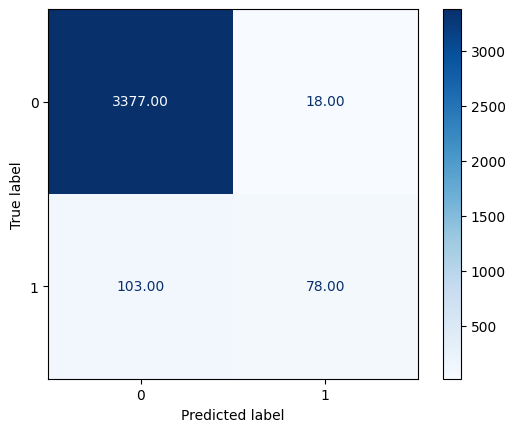

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


#confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay.from_estimator(
    lr,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    values_format=".2f",
)



Recall Score

In [26]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)


0.430939226519337

SMOTE

In [29]:
pip install imblearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.5 MB/s eta 0:00:00


In [30]:
from imblearn.over_sampling import SMOTE
y_train.value_counts()



,count
fraudulent,
0,13619
1,685


In [32]:
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

In [33]:
np.bincount(y_train)

array([13619, 13619])

In [35]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8791946308724832
Recall: 0.8397790055248618


MLP Classifer

In [39]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)


In [36]:
pip install tabulate

Evaluate Model

In [37]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score, recall_score
from sklearn.base import clone
from tabulate import tabulate

# To tabulate evluation metrics and compare models with reusable code
def evaluate_model(model, X_train, Y_train, X_test, Y_test,alpha=None):
    # copy model to avoid overwriting the original model
    model_copy = clone(model)

    if alpha is not None and hasattr(model_copy, 'alpha'):
        model_copy.alpha = alpha

    model_copy.fit(X_train, Y_train)
    y_pred = model_copy.predict(X_test)

    acc = accuracy_score(y_pred, Y_test)
    kappa = cohen_kappa_score(y_pred, Y_test)
    precision = precision_score(y_pred, Y_test,average='weighted')
    recall = recall_score(y_pred, Y_test,average='weighted')

    return model_copy, acc, kappa, precision, recall

In [40]:

metrics = []
metrics.append(evaluate_model(clf, X_train, y_train, X_test, y_test))


headers = ["Model", "Accuracy", "Kappa", "Precision", "Recall"]
markdown_table = tabulate(metrics, headers=headers, tablefmt="github")
print(markdown_table)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


| Model                                       |   Accuracy |    Kappa |   Precision |   Recall |
|---------------------------------------------|------------|----------|-------------|----------|
| MLPClassifier(max_iter=300, random_state=1) |   0.955257 | 0.601195 |    0.951102 | 0.955257 |


In [43]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.3 MB/s eta 0:00:00


In [45]:
#XGBoost

from sklearn.metrics import explained_variance_score
import xgboost as xgb


xgb_reg = xgb.XGBRegressor(objective="reg:linear", n_estimators=75, subsample=0.75, max_depth=7)
xgb_reg.fit(X_train, y_train)

# Making Predictions
predictions = xgb_reg.predict(X_test)

# Variance_score
print((explained_variance_score(predictions, y_test)))

# To convert data table into a matrix
#kc_dmatrix = xgb.DMatrix(data=X, label=y, feature_names=jobs_encoded_scaled)

# Create the parameter dictionary: params
#params = {"objective": "reg:linear", "max_depth": 2}

# Train the model: xg_reg
#xg_reg = xgb.train(params=params, dtrain=kc_dmatrix, num_boost_round=10)

# Plot the first tree as num_trees = 0 and features importance
#xgb.plot_tree(xg_reg, num_trees=0)
#xgb.plot_importance(xg_reg)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:09:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


0.14743887009071388
